In [3]:
conda install qutip

^C

Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c conda-forge kwant

In [13]:
conda install -c pytorch pytorch-cuda

^C

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
device=torch.device('cuda')

In [15]:
a = torch.arange(60.).reshape(3, 4, 5)
b = torch.arange(24.).reshape(4, 3, 2)

In [4]:
torch.tensordot(a, b, dims=([1, 0], [0, 1]))

tensor([[4400., 4730.],
        [4532., 4874.],
        [4664., 5018.],
        [4796., 5162.],
        [4928., 5306.]])

In [4]:
torch.cuda.is_available()

True

In [11]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [16]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 424),
             ('active.all.current', 25),
             ('active.all.freed', 399),
             ('active.all.peak', 28),
             ('active.large_pool.allocated', 58),
             ('active.large_pool.current', 0),
             ('active.large_pool.freed', 58),
             ('active.large_pool.peak', 2),
             ('active.small_pool.allocated', 366),
             ('active.small_pool.current', 25),
             ('active.small_pool.freed', 341),
             ('active.small_pool.peak', 28),
             ('active_bytes.all.allocated', 5193980928),
             ('active_bytes.all.current', 590336),
             ('active_bytes.all.freed', 5193390592),
             ('active_bytes.all.peak', 2684945408),
             ('active_bytes.large_pool.allocated', 5179965440),
             ('active_bytes.large_pool.current', 0),
             ('active_bytes.large_pool.freed', 5179965440),
             ('active_bytes.large_pool.peak', 2684354560),
          

In [17]:
torch.cuda.max_split_size_mb 

AttributeError: module 'torch.cuda' has no attribute 'max_split_size_mb'

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import kwant

ModuleNotFoundError: No module named 'kwant'

In [10]:
def Jordan_wigner_transform(j, lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators = torch.tensor([[1,0],[0,-1]],dtype = torch.int)
    for _ in range(j-1): operators = torch.kron(operators, torch.tensor([[1,0],[0,-1]],dtype = torch.int))
    if j == 0: operators = torch.tensor([[0,0],[1,0]],dtype = torch.int)
    else: operators = torch.kron(operators, torch.tensor([[0,0],[1,0]],dtype = torch.int))
    for _ in range(lattice_length - j - 1): operators = torch.kron(operators, torch.tensor([[1,0],[0,1]],dtype = torch.int))
    print(j)
    return operators.to(torch.float)

def Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2):
    """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
    return -(1/(omega-Ed-Sigma+1j*Gamma)).imag/np.pi, torch.tensor([Gamma * torch.tan(np.pi * (pi - 1 / 2))+Ed+Sigma for pi in torch.rand(poles)])

def Startrans(poles,select,omega, eta,row=0):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    Pbath,Dbath,pbar,G=torch.zeros(poles, poles),torch.zeros(poles,poles),torch.zeros(poles, poles),torch.zeros(len(omega),dtype = torch.cfloat)
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i: Pbath[i+1][j+1]=-1/np.sqrt((poles-i-1)*(poles-i))
        Pbath[i+1][i]=np.sqrt(poles-i-1)/np.sqrt(poles-i)
    Pbath[row,:]=1/np.sqrt(poles)
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar[1:,1:]=torch.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
    pbar[row][row]=1
    for i, _ in enumerate(select): G+=1 / len(select) / (omega - select[i] + 1.j * eta)
    return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma, H0 = 0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for i in range(2):
        H0 += impenergy * c[i].T@c[i]
        for j, bathE in enumerate(bathenergy):
            H0 += Vkk[j] * (c[i].T@c[2 * j + i + 2]+c[2 * j + i + 2].T@c[i])+ bathE * c[2 * j + i + 2].T@c[2 * j + i + 2]
    return H0,H0+U * c[0].T@c[0]@c[1].T@c[1]-Sigma * (c[0].T@c[0]+c[1].T@c[1])

def Constraint(ctype,H0,H,omega,eta,c,n,Tk,Nfin):
    """Constraint(ctype,H0,H,omega,eta,c,n). 
Constraint implementation function for DED method with various possible constraints."""
    if ctype[0]=='n':
        eigs=torch.linalg.eigh(H)
        vecs=torch.vstack((torch.linalg.eigh(H0)[1][:,0],eigs[1][:,0]))
        exp=torch.mm(torch.conj(vecs),torch.mm(n,vecs.T))
        if ctype=='n' and torch.round(exp[0,0])==torch.round(exp[1,1]):
            return MBGAIM(omega, H, c, eta,Tk,torch.ones(len(Tk)),eigs[0],eigs[1]),True
        else:
            return (torch.zeros(len(omega),dtype = torch.cfloat),torch.zeros(len(Tk)),torch.tensor([])),False
    else:
        return MBGAIM(omega, H, c, eta,Tk,torch.ones(len(Tk))),True

def MBGAIM(omega, H, c, eta,Tk,Boltzmann,evals,evecs,etaoffset=1e-4,posoffset=np.zeros(1,dtype='int')):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    if ~torch.any(evals): evals,evecs=torch.linalg.eigh(H)
    vecn=torch.conj(evecs[:,1:]).T
    exp,exp2=vecn@c[0]@evecs[:,0],vecn@c[0].T@evecs[:,0]
    return MBGT0(omega,eta,evals,exp,exp2),Boltzmann,evecs[:,0]

def MBGT0(omega,eta,evals,exp,exp2):
    G=torch.zeros(len(omega),dtype = torch.cfloat)
    for i,expi in enumerate(exp): G+=torch.abs(expi)** 2 / (omega + evals[i+1] - evals[0] + 1.j * eta) + torch.abs(exp2[i])** 2 / (omega + evals[0] - evals[i+1] + 1.j * eta)
    return G

In [11]:
import scipy

In [12]:
from tqdm import trange

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
torch.set_default_device(device)

In [6]:
#torch.backends.cuda.matmul.allow_tf32 = True

In [46]:
U=3
Ed=-3/2
Sigma=3/2
Gamma=0.3
poles=2
c=[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]
bound=3
SizeO=1001
etaco=[0.02,1e-24]
omega= torch.linspace(-bound,bound,SizeO)
eta=etaco[0]*abs(torch.linspace(-bound,bound,SizeO))+etaco[1]
Tk=[0]
Nfin=torch.zeros(len(Tk),dtype = torch.float)
AvgSigmadat=torch.zeros((len(Tk),SizeO),dtype = torch.cfloat)
nd=torch.zeros(len(Tk),dtype = torch.float)
ctype='n'
n=sum([torch.mm(c[i].T,c[i]) for i in range(2*poles)])
N=100
posb=0
pbar=trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

while (torch.tensor([ar<N for ar in Nfin]).any() and ctype!='sn'):
    reset = False
    while not reset:
        NewM,nonG,select=Startrans(poles,torch.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]).values,omega,eta)
        H0,H=HamiltonianAIM(c,NewM[0][0],[NewM[k+1][k+1] for k in range(len(NewM)-1)],NewM[0,1:],U,Sigma)
        (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,torch.tensor([ar<N for ar in Nfin]))
    Nfin=Nfin+Boltzmann
    AvgSigmadat=AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None]
    nd=nd+torch.conj(Ev0).T@(c[0].T@c[0] + c[1].T@c[1])@Ev0*Boltzmann
    if ctype=='sn': pbar.n=len(selectpcT)
    else: pbar.n+=1
    pbar.refresh()
pbar.close()
pbar.format_dict["elapsed"]


0
1
2
3


3.3022875785827637

In [45]:

pbar.format_dict["elapsed"],

5.815404653549194

In [29]:
pbar.format_dict

{'n': 200,
 'total': 200,
 'elapsed': 20.99770212173462,
 'ncols': None,
 'nrows': None,
 'prefix': 'Iterations',
 'ascii': False,
 'unit': 'it',
 'unit_scale': False,
 'rate': None,
 'bar_format': '{l_bar}{bar:10}{r_bar}{bar:-10b}',
 'postfix': None,
 'unit_divisor': 1000,
 'initial': 0,
 'colour': None}

In [172]:
omega= torch.linspace(-bound,bound,SizeO)
fdos=(-torch.imag(1/(omega-AvgSigmadat/Nfin[:,None]-Ed+1j*Gamma))/np.pi).squeeze().to(device="cpu")

In [147]:
import matplotlib.pyplot as plt

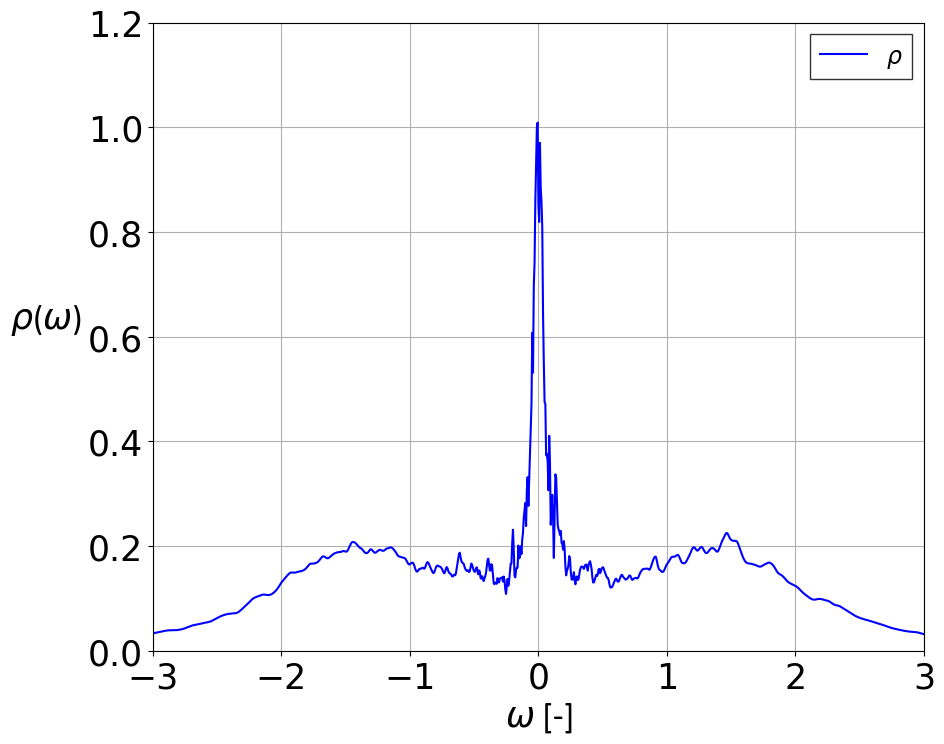

In [173]:
    omega=omega.to(device="cpu")
    plt.figure(figsize=(10,8))
    plt.rc('legend', fontsize=17)
    plt.rc('font', size=25)
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    axis_font = {'fontname':'Calibri', 'size':'25'}
    plt.xlim(min(omega), max(omega))
    plt.gca().set_ylim(bottom=0,top=1.2)
    plt.xlabel("$\\omega$ [-]", **axis_font)
    plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=30,**axis_font)
    #plt.plot(omega,Lor, '--r',linewidth=4,label='$\\rho_0$')
    plt.plot(omega,fdos,'-b',label='$\\rho$')
    plt.legend(fancybox=False).get_frame().set_edgecolor('black')
    plt.grid()
    plt.tight_layout()

In [56]:
poles=8
c=[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]

KeyboardInterrupt: 

In [53]:
c

[tensor(indices=tensor([[2048, 2049, 2050,  ..., 4093, 4094, 4095],
                        [   0,    1,    2,  ..., 2045, 2046, 2047]]),
        values=tensor([1, 1, 1,  ..., 1, 1, 1]),
        size=(4096, 4096), nnz=2048, layout=torch.sparse_coo),
 tensor(indices=tensor([[1024, 1025, 1026,  ..., 4093, 4094, 4095],
                        [   0,    1,    2,  ..., 3069, 3070, 3071]]),
        values=tensor([ 1,  1,  1,  ..., -1, -1, -1]),
        size=(4096, 4096), nnz=2048, layout=torch.sparse_coo),
 tensor(indices=tensor([[ 512,  513,  514,  ..., 4093, 4094, 4095],
                        [   0,    1,    2,  ..., 3581, 3582, 3583]]),
        values=tensor([1, 1, 1,  ..., 1, 1, 1]),
        size=(4096, 4096), nnz=2048, layout=torch.sparse_coo),
 tensor(indices=tensor([[ 256,  257,  258,  ..., 4093, 4094, 4095],
                        [   0,    1,    2,  ..., 3837, 3838, 3839]]),
        values=tensor([ 1,  1,  1,  ..., -1, -1, -1]),
        size=(4096, 4096), nnz=2048, layout=torch.s

In [31]:
crow_indices = [0, 1, 2]
col_indices = [0,1]
values = [1,-1]
csr=torch.sparse_csr_tensor(torch.tensor(crow_indices, dtype=torch.int64),torch.tensor(col_indices, dtype=torch.int64),torch.tensor(values), dtype=torch.double)

In [39]:
torch.tensor([[1,0],[0,-1]])[1]

tensor([ 0, -1])

In [36]:
sigmaz=torch.tensor([[1,0],[0,-1]])
torch.kron(sigmaz, sigmaz)

tensor([[ 1,  0,  0,  0],
        [ 0, -1,  0,  0],
        [ 0,  0, -1,  0],
        [ 0,  0,  0,  1]])

In [16]:
torch.sparse_csr_tensor(torch.tensor([0,2,2], dtype=torch.int64),torch.tensor([0,1], dtype=torch.int64),torch.tensor([1,-1]))

RuntimeError: (Batch element 0) last value of crow_indices should be equal to the length of col_indices.

In [3]:
a,b

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.]],
 
         [[20., 21., 22., 23., 24.],
          [25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39.]],
 
         [[40., 41., 42., 43., 44.],
          [45., 46., 47., 48., 49.],
          [50., 51., 52., 53., 54.],
          [55., 56., 57., 58., 59.]]]),
 tensor([[[ 0.,  1.],
          [ 2.,  3.],
          [ 4.,  5.]],
 
         [[ 6.,  7.],
          [ 8.,  9.],
          [10., 11.]],
 
         [[12., 13.],
          [14., 15.],
          [16., 17.]],
 
         [[18., 19.],
          [20., 21.],
          [22., 23.]]]))